# Modern BERT Fine-Tuning for Multiclass Classification
* Notebook by Adam Lang
* Date: 2/27/25

# Overview
* In this notebook we will fine-tune Modern BERT for Multiclass Classification.

# Modern BERT Model
* Model card: https://huggingface.co/answerdotai/ModernBERT-base
* ModernBERT is a modernized bidirectional encoder-only Transformer model (BERT-style) pre-trained on 2 trillion tokens of English and code data with a native context length of up to 8,192 tokens.
* ModernBERT leverages recent architectural improvements such as:

1. Rotary Positional Embeddings (RoPE) for long-context support.
2. Local-Global Alternating Attention for efficiency on long inputs.
3. Unpadding and Flash Attention for efficient inference.
4. Increased context length
  * BERT was limited to a maximum context length of 512 tokens.
  * ModernBERT: Supports a significantly larger context length of 8,192 tokens, allowing for better handling of long documents and complex queries.

* Good review article: https://medium.com/data-science-in-your-pocket/modernbert-vs-bert-whats-the-difference-b8d29313231f#:~:text=BERT%3A%20Limited%20to%20a%20maximum,long%20documents%20and%20complex%20queries.

## Use Cases
* This updated version of BERT makes it ideal for NLP tasks that require processing long context sequences in large corpora or documents such as:
  * information retrieval
  * classification
  * semantic search  

* Since the model was trained on a large corpus of text and code, it excels at a variety of downstream tasks, including:
  * code retrieval
  * hybrid (text + code) semantic search
  * ...and much more.


# Install Dependencies

In [1]:
%%capture
!pip install "torch==2.5.0" "torchvision==0.20.0"

In [2]:
%%capture
!pip install "setuptools<71.0.0" scikit-learn

In [3]:
%%capture
!pip install -U\
 "datasets==3.1.0"\
 "accelerate==1.2.1"\
 "hf-transfer==0.1.8"

# Imports

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,

)
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict, IterableDatasetDict
from datasets.iterable_dataset import IterableDataset

# Load Dataset from hugging face
* dataset: `argilla/synthetic-domain-text-classification`
* data card: https://huggingface.co/datasets/argilla/synthetic-domain-text-classification
* This is a synthetic dataset that has 26 different classes for multi-class classification.

In [77]:
## load hf dataset
data_id = "argilla/synthetic-domain-text-classification"

## train split
train_data = load_dataset(data_id, split='train')

## test split
split_data = train_data.train_test_split(test_size=0.30)
split_data['train'][1:10]

{'text': ["The game was an epic showdown between the two rival teams. The stadium was packed as fans eagerly anticipated the clash. Both teams had been performing well this season and were hungry for victory. As the match began, tension filled the air. The defense of Team A was formidable, thwarting multiple attempts by Team B to score. However, in a surprising turn of events, a skillful maneuver led Team B's striker to break through the defenses, scoring the first goal against all odds. This ignited a fierce battle that continued until the final whistle. Fans were left on the edge of their seats as both teams fought fiercely for supremacy.",
  'The recent financial crisis has affected various sectors of the global economy. Banks have experienced decreased liquidity as credit markets tightened, leading to higher borrowing costs for consumers and businesses alike. This situation has prompted governments around the world to implement economic stimulus packages aimed at boosting demand an

In [78]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

# Exploratory Data Analysis
1. Visualize the target class to check for any imbalance in the labels.
2. Evaluate the token sequence lengths in the text column. Not that we will have any issues with the max sequence length of Modern BERT being 8,192 tokens much more than the 512 tokens for the original BERT model but still good practice to check this for batching when feeding tokens to the model.

## Visualize Target Labels

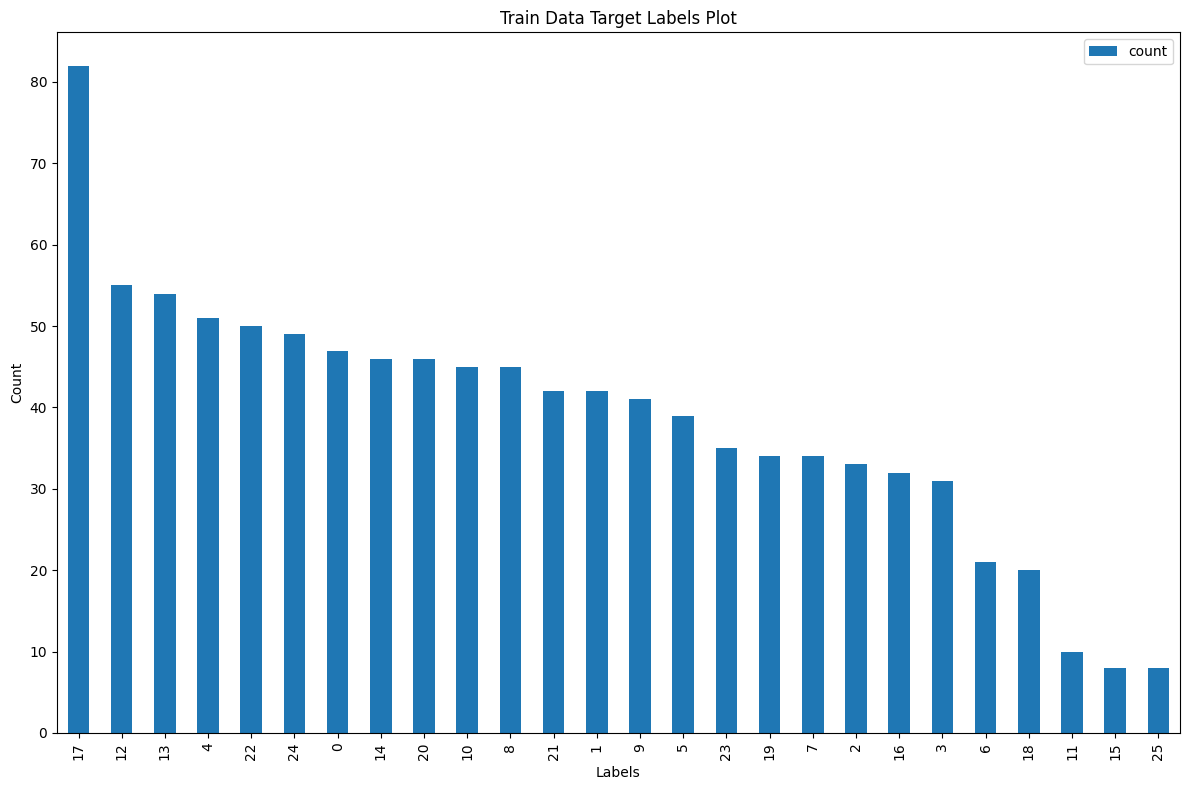

In [79]:
## train data
plt.figure(figsize=(12,8))
## call to_pandas() on the train_data['label'] object
pd.DataFrame(train_data['label'], columns=['label'])['label'].value_counts().plot(kind='bar')

plt.title('Train Data Target Labels Plot')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show();

Summary
* It appears that Label 17 from the dataset has a higher frequency while labels 11, 15, and 25 have a much lower frequency.
* We will see how the model performs in clasification, but obviously if it does not perform well we may need to consider resampling the target labels to even out the distribution.

## Count Tokens in text column
* Counting token min, max, and mean will just give us an idea of the token counts for the text column. As I mentioned above we really don't have to worry about this now because Modern Bert has a longer sequence length than the standard BERT model (512), but it is still best practice to know this.

In [80]:
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

In [81]:
from tqdm import tqdm
from transformers import AutoTokenizer
import pandas as pd

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('answerdotai/ModernBERT-base')

# Function to count tokens
def count_tokens(text):
    return len(tokenizer.encode(text))

# Convert the 'text' column to a Pandas Series
text_series = pd.Series(train_data['text'])

# Apply the function with a progress bar
tqdm.pandas(desc="Counting tokens")  # Initialize tqdm for Pandas
token_counts = text_series.progress_apply(count_tokens) # Use progress_apply on the Pandas Series

# Instead of adding a new column, update the existing 'token_count_text' column
train_data = train_data.add_column('token_count_text', token_counts.to_list()) # Add the token counts as a new column to the Dataset



Counting tokens: 100%|██████████| 1000/1000 [00:00<00:00, 1567.70it/s]


In [82]:
# Display the value counts
print(f"Max tokens: {np.max(train_data['token_count_text'])}")
print(f"Max tokens: {np.min(train_data['token_count_text'])}")
print(f"Std tokens: {np.std(train_data['token_count_text']):.3f}")

# Extract 'token_count_text' as a list
token_counts = train_data['token_count_text']

# Calculate the mean
mean_token_count = np.mean(token_counts)

print(f"Mean token count: {mean_token_count}")

Max tokens: 374
Max tokens: 40
Std tokens: 29.849
Mean token count: 97.518


Summary
* It's clear the token counts are not an issue in the text column for the Modern BERT sequence length.
* However, it is an NLP consideration as we have to consider if there is enough context in the text column for the model to learn and predict the each label.

# Load Modern BERT checkpoint & Tokenizer

In [83]:
## model checkpoint modern bert
model_ckpt = 'answerdotai/ModernBERT-base'


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

PreTrainedTokenizerFast(name_or_path='answerdotai/ModernBERT-base', vocab_size=50280, model_max_length=8192, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("|||IP_ADDRESS|||", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	1: AddedToken("<|padding|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50254: AddedToken("                        ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50255: AddedToken("                       ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50256: AddedToken("                      ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50257: AddedToken("                    

In [84]:
## lets see the tokenizer vocab size
tokenizer.vocab_size

50280

In [85]:
## tokenizer special tokens
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [86]:
## function to tokenze text
def tokenize(batch):
  return tokenizer(batch['text'],
                   truncation=True,
                   padding=True,
                   return_tensors='pt')

## tokenize data and rename columns to align with HF Trainer
if "label" in split_data['train'].features.keys():
  split_data = split_data.rename_column('label', 'labels') ## match Trainer
tokenized_data = split_data.map(tokenize,
                                batched=True,
                                remove_columns=['text'])

tokenized_data['train'].features.keys()

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

dict_keys(['labels', 'input_ids', 'attention_mask'])

# Load Model & id2label, label2id mapping
* We load the model then map the id2label and label2id for the classification task.

In [87]:
## model ckpt loaded above but load again
model_ckpt = "answerdotai/ModernBERT-base"


## mapping of id2label and label2id
## 1. get labels
labels = tokenized_data['train'].features['labels'].names
## 2. get num labels
num_labels = len(labels)
## 3. mapping of labels --> dictionary objects
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = str(i)
  id2label[str(i)] = label


## 4. load model with labels and ids mapped
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [88]:
## now lets see the labels
pd.DataFrame(labels)

,0
0,business-and-industrial
1,books-and-literature
2,beauty-and-fitness
3,autos-and-vehicles
4,people-and-society
5,sports
6,shopping
7,online-communities
8,pets-and-animals
9,internet-and-telecom


In [89]:
## total labels
print(f"Total labels: {len(labels)}")

Total labels: 26


# Setup Evaluation Metrics
* We will set up 3 instance of evaluation metrics using
1. Evaluate library from hugging face
2. Sklearn
3. PyTorch Lightning (Torchmetrics)

* However, I will only use 1 of these for model evaluation.

In [41]:
%%capture
!pip install evaluate

## 1. Evaluate Metrics from hugging face

In [90]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(predictions_and_labels):
    predictions, labels = predictions_and_labels

    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

## 2. Evaluate using Sklearn

In [45]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_sklearn(predictions_and_labels):
    predictions, labels = predictions_and_labels

    if len(predictions.shape) >= 2:
        predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

## 3. Evaluate using PyTorch Lightning
* In the PyTorch Lightning version, the metrics are calculated and logged during the training process.
* You don't need a separate evaluation function as the metrics are integrated into the model class.




In [ ]:
import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall, F1Score

class BERTClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # ... (your BERT model initialization here)

        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = Precision(task="multiclass", num_classes=num_classes, average='weighted')
        self.recall = Recall(task="multiclass", num_classes=num_classes, average='weighted')
        self.f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted')

    def training_step(self, batch, batch_idx):
        # ... (your training step logic here)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
        self.f1(preds, y)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy, prog_bar=True)
        self.log('val_precision', self.precision, prog_bar=True)
        self.log('val_recall', self.recall, prog_bar=True)
        self.log('val_f1', self.f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # Similar to validation_step, but for test data

    def on_validation_epoch_end(self):
        self.log('val_acc_epoch', self.accuracy.compute())
        self.log('val_precision_epoch', self.precision.compute())
        self.log('val_recall_epoch', self.recall.compute())
        self.log('val_f1_epoch', self.f1.compute())

    def on_test_epoch_end(self):
        # Similar to on_validation_epoch_end, but for test data

# Setup Trainer and Training Arguments
* Prepare the model for training.
* More about why to use bf16 and memory here: https://cloud.google.com/tpu/docs/bfloat16

In [91]:
# from transformers import Trainer, TrainingArguments ## uncomment if havent loaded above

## 1. define training args
training_args = TrainingArguments(
    output_dir='ModernBERT-multiclass-classification',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=0.001,
    num_train_epochs=5,
    bf16=True, #brain float 16 training -- bfloat16 uses 1/2 of memory spac of float32
    optim="adamw_torch_fused", # improved optimizer
    ## logging and evaluation of results
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2, ## only save 2 versions of model
    use_cpu=False,
    seed=42,
    load_best_model_at_end=True,
    report_to='none', #not reporting to external platform
    #hub_token=
    #push_to_hub=True ##if pushing to HF hub after training
    hub_private_repo=False #when uploading to Hugging Face hub, do you want repo to private or public (default=public)
)


## 2. Trainer instance
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    compute_metrics=compute_metrics,
)


## train model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,3.451400,3.289238,0.130000,0.030114,0.130000,0.047640
2,2.700100,2.569449,0.213333,0.089487,0.213333,0.117995
3,2.060000,2.185991,0.313333,0.329893,0.313333,0.254453
4,1.505300,1.864939,0.460000,0.441564,0.460000,0.428088
5,0.884900,2.002498,0.520000,0.529445,0.520000,0.489330


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

TrainOutput(global_step=875, training_loss=2.1203426339285714, metrics={'train_runtime': 776.4425, 'train_samples_per_second': 4.508, 'train_steps_per_second': 1.127, 'total_flos': 871340305836000.0, 'train_loss': 2.1203426339285714, 'epoch': 5.0})

# Evaluation & Loss Curves
* Loss curves are a good visualization of your model's performance over time.
* Ideally, loss curves will trend downwards.

In [92]:
## get training history
trainer_history_all = trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[:-1]

# View first 3
trainer_history_metrics[:3]


[{'loss': 3.4514,
  'grad_norm': 2.544252872467041,
  'learning_rate': 0.0008,
  'epoch': 1.0,
  'step': 175},
 {'eval_loss': 3.289238214492798,
  'eval_accuracy': 0.13,
  'eval_precision': 0.03011354420113544,
  'eval_recall': 0.13,
  'eval_f1': 0.047639896608017415,
  'eval_runtime': 7.2457,
  'eval_samples_per_second': 41.404,
  'eval_steps_per_second': 20.702,
  'epoch': 1.0,
  'step': 175},
 {'loss': 2.7001,
  'grad_norm': 4.221950531005859,
  'learning_rate': 0.0006,
  'epoch': 2.0,
  'step': 350}]

In [93]:
## extract training metrics
import pprint

# Extract eval and training metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through our metrics
for item in trainer_history_metrics:
  item_keys = list(item.keys())
  if any("eval" in item for item in item_keys):
    trainer_history_eval_set.append(item)
  else:
    trainer_history_training_set.append(item)

# Show first item from each
print(f"First item in training set:")
pprint.pprint(trainer_history_training_set[:2])

print(f"\nFirst two items in eval epochs:")
pprint.pprint(trainer_history_eval_set[:2])

First item in training set:
[{'epoch': 1.0,
  'grad_norm': 2.544252872467041,
  'learning_rate': 0.0008,
  'loss': 3.4514,
  'step': 175},
 {'epoch': 2.0,
  'grad_norm': 4.221950531005859,
  'learning_rate': 0.0006,
  'loss': 2.7001,
  'step': 350}]

First two items in eval epochs:
[{'epoch': 1.0,
  'eval_accuracy': 0.13,
  'eval_f1': 0.047639896608017415,
  'eval_loss': 3.289238214492798,
  'eval_precision': 0.03011354420113544,
  'eval_recall': 0.13,
  'eval_runtime': 7.2457,
  'eval_samples_per_second': 41.404,
  'eval_steps_per_second': 20.702,
  'step': 175},
 {'epoch': 2.0,
  'eval_accuracy': 0.21333333333333335,
  'eval_f1': 0.1179946623232577,
  'eval_loss': 2.5694494247436523,
  'eval_precision': 0.0894869210608458,
  'eval_recall': 0.21333333333333335,
  'eval_runtime': 7.4179,
  'eval_samples_per_second': 40.443,
  'eval_steps_per_second': 20.221,
  'step': 350}]


In [94]:
## create pandas df for training and eval metrics
trainer_history_train_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

## trainer df head - train data
trainer_history_eval_df.head()

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,3.289238,0.130000,0.030114,0.130000,0.047640,7.2457,41.404,20.702,1.0,175
1,2.569449,0.213333,0.089487,0.213333,0.117995,7.4179,40.443,20.221,2.0,350
2,2.185991,0.313333,0.329893,0.313333,0.254453,7.2859,41.175,20.588,3.0,525
3,1.864939,0.460000,0.441564,0.460000,0.428088,7.4949,40.027,20.014,4.0,700
4,2.002498,0.520000,0.529445,0.520000,0.489330,7.2925,41.138,20.569,5.0,875


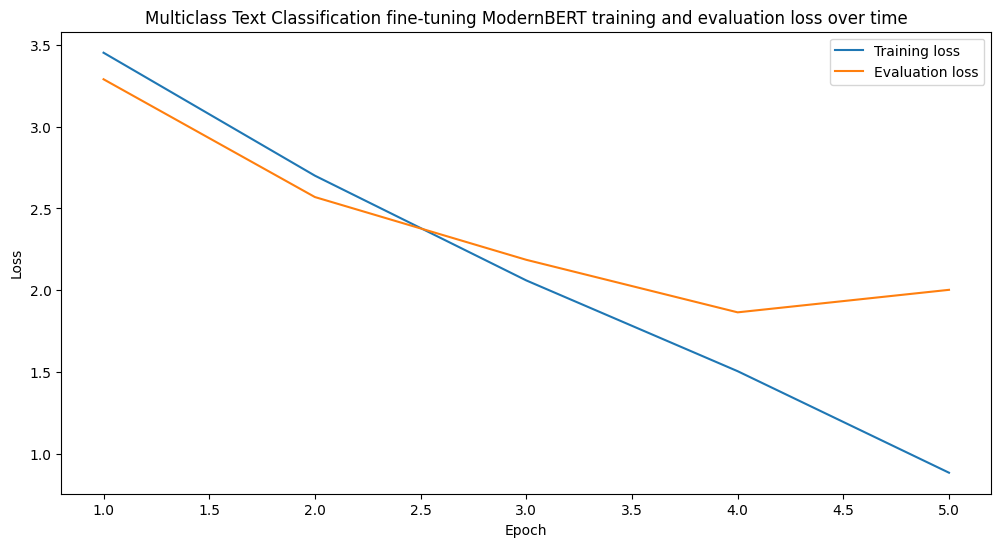

In [95]:
# plot loss curves
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(trainer_history_train_df['epoch'], trainer_history_train_df['loss'], label="Training loss")
plt.plot(trainer_history_eval_df['epoch'], trainer_history_eval_df['eval_loss'], label="Evaluation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Multiclass Text Classification fine-tuning ModernBERT training and evaluation loss over time")
plt.legend()
plt.show();

Summary
* We can see that both the train and eval loss went down over 5 epochs and if we kept training im sure that the train loss would have continued to go down.
* 1 epoch may have been enough as it appears the eval loss was less than the train loss but then it switched and the eval loss was more than the train loss.
* I alrady tried some optimization techniques to get to this point including:
  1. increasing test set size from 10% to 30%.
  2. Lowering the learning rate.
  3. Training for more epochs.

* I appears that the model is now Overfitting which is when the training loss continues to decrease while the validation (eval) loss starts to increase, this is a clear indication of overfitting.
  * It means the model is learning to fit the training data too closely, including its noise and peculiarities, at the expense of generalizing well to unseen data.


Learning Curve:

In this scenario, the diverging trends of training and validation loss create a characteristic "fork" in the learning curve, which is a telltale sign of overfitting.

What This Means:

The model is performing increasingly well on the training data but is losing its ability to generalize to new, unseen data (represented by the validation set).

The model is likely capturing noise or specific details in the training data that don't generalize to the validation set.

Actions to Consider:

1. Regularization: Increase regularization (L1, L2, dropout) to prevent the model from fitting the training data too closely.

2. Data Augmentation: Increase the diversity of the training data to help the model learn more generalizable features.

3. Reduce Model Complexity: If the model is very large or deep, consider simplifying it.

4. Early Stopping: Implement early stopping to halt training when validation performance starts to degrade.

5. Cross-Validation: Use k-fold cross-validation to ensure this trend is consistent across different data splits.

6. More Data: If possible, collect more training data to give the model more examples to learn from.

7. Feature Selection/Engineering: Revisit the features to ensure we are providing the most relevant information to the model.

8. Ensemble Methods: Consider using ensemble methods which can help in reducing overfitting.

9. Batch normalization, gradient clipping and other methods.

# Predictions & Inference

In [96]:
## get predictions on test set
preds = trainer.predict(tokenized_data['test'])

## process prediction results --> preds, label_ids, metrics
pred_labels = np.argmax(preds.predictions, axis=1)
pred_label = id2label[str(pred_labels[0])]
example_data = [split_data['train'][0]]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
## print predicted vs. actual
print(f"Predicted Label: {pred_label}")
print(f"Actual Label: {id2label[str(example_data[0]['labels'])]}")

Predicted Label: health
Actual Label: business-and-industrial


In [98]:
## shoe pred labels
pred_labels

array([17, 14, 23, 23, 17, 14, 22,  4, 13,  9, 19, 23,  9,  4, 23, 17, 14,
        5,  7, 16,  1,  8,  4, 13, 17,  4,  1, 12, 20,  8,  1, 10, 14,  1,
        6, 17,  1,  1,  5, 22, 23, 14, 17, 20, 13,  0, 14, 17,  1, 19, 18,
       17,  1, 22, 17,  8, 23,  1, 10, 14, 10,  8, 10,  5, 17, 13,  1, 22,
       10,  1,  8,  4, 22, 14,  5, 23,  8, 17,  8, 20, 23,  9, 17,  1, 13,
        2,  1, 19, 20, 14,  1, 19, 17, 19, 14, 22, 20,  4,  3, 23,  0,  4,
        5,  9, 17, 10, 14,  1,  3,  1,  9, 12,  3, 10, 12,  1, 23,  3, 17,
       17, 12,  1,  6,  1, 23, 10,  4,  4, 22,  9, 17, 12, 22,  1, 19,  1,
       19, 14,  3, 17,  5,  6,  8,  1, 14,  9, 22, 20,  1,  6, 23,  0, 23,
        6,  9, 12,  7, 23, 10,  6, 16,  4, 13,  4,  5, 20, 23,  7, 14, 17,
       23, 23, 19, 20,  8,  3,  5, 23,  7, 23, 13, 17,  1, 23,  8,  5, 23,
       10,  2,  7, 14, 13, 19,  9,  1,  1,  1, 14,  9,  7, 23,  0,  1, 23,
        3,  8, 12,  6,  2, 23, 20, 13, 17, 12, 12,  2, 16,  5,  8,  3, 19,
       22,  9,  7,  2,  2